# 1. Original Model

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from paths import names

In [ ]:
# read in all the words
words = open(names, "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()} # test
vocab_size = len(itos)
print(itos)# test
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182609, 3]) torch.Size([182609])
torch.Size([22866, 3]) torch.Size([22866])
torch.Size([22671, 3]) torch.Size([22671])


In [6]:
# MLP revisited
n_embd = 10
n_hidden = 180

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch
    xi = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[xi], Ytr[xi]

    # forward pass
    emb = C[Xb]  # embedding the charachters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[xi])

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 12000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:
        print(f"{i:7d}/{max_steps:7}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


def train_model():

    for i in range(max_steps):

        # minibatch
        xi = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[xi], Ytr[xi]

        # forward pass
        emb = C[Xb]  # embedding the charachters into vectors
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)  # (32, 200)
        logits = h @ W2 + b2  # (32, 27)
        loss = F.cross_entropy(logits, Ytr[xi])

        # backward pass

        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 12000 else 0.01

        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % (max_steps / 8) == 0:
            print(f"{i:7d}/{max_steps:7}: {loss.item():.4f}")
        lossi.append(loss.log10().item())



    @torch.no_grad()
    def split_loss(split):
        x,y = {
            'train': (Xtr, Ytr),
            'val': (Xdev, Ydev),
            'test': (Xte, Yte)
        } [split]
        emb = C[x]
        embcat = emb.view(emb.shape[0], -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y)
        print(split, loss.item())

    split_loss('train')
    split_loss('val')

      0/  10000: 3.3016
   1250/  10000: 2.1562
   2500/  10000: 2.4904
   3750/  10000: 2.6904
   5000/  10000: 2.2189
   6250/  10000: 2.0703
   7500/  10000: 2.4296
   8750/  10000: 2.3244


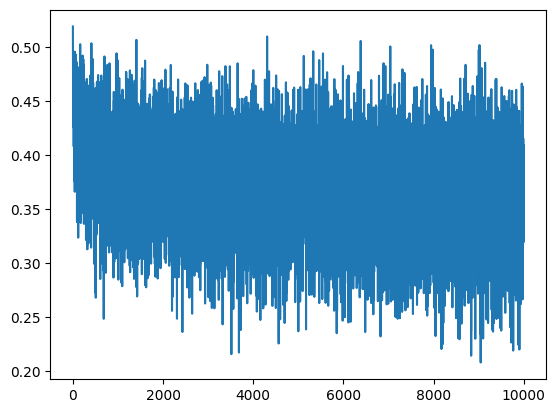

In [8]:
# plt.plot((1,2,3,4,),(7,9,0,4))
plt.plot(lossi)

Training Error

In [139]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    } [split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.298316240310669
val 2.333397388458252


Validation Error

# 2. Improving performance

## 2.1 Overconfident Initialization

- At the start we can know what the error should be, but it's much higher because it starts super overconfident

- We can improve performance by setting second set of biases to 0 and for second set of weights `* 0.01`

- This worked right away

## 2.2 Fixing activation function tails


Getting Histogram of all values of h

- almost only 1 and -1

(array([2079.,  145.,   86.,   69.,   52.,   51.,   30.,   30.,   35.,
          29.,   23.,   36.,   37.,   27.,   18.,   28.,   25.,   20.,
          10.,   17.,   21.,   20.,   15.,   18.,   14.,   13.,   29.,
          23.,   11.,   18.,   22.,   29.,   16.,   12.,   14.,   17.,
          15.,   32.,   17.,   26.,   33.,   37.,   39.,   45.,   47.,
          41.,   42.,   80.,  137., 2030.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

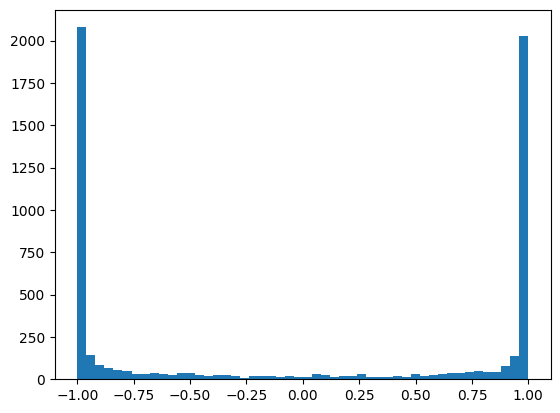

In [140]:
plt.hist(h.view(-1).tolist(), 50)

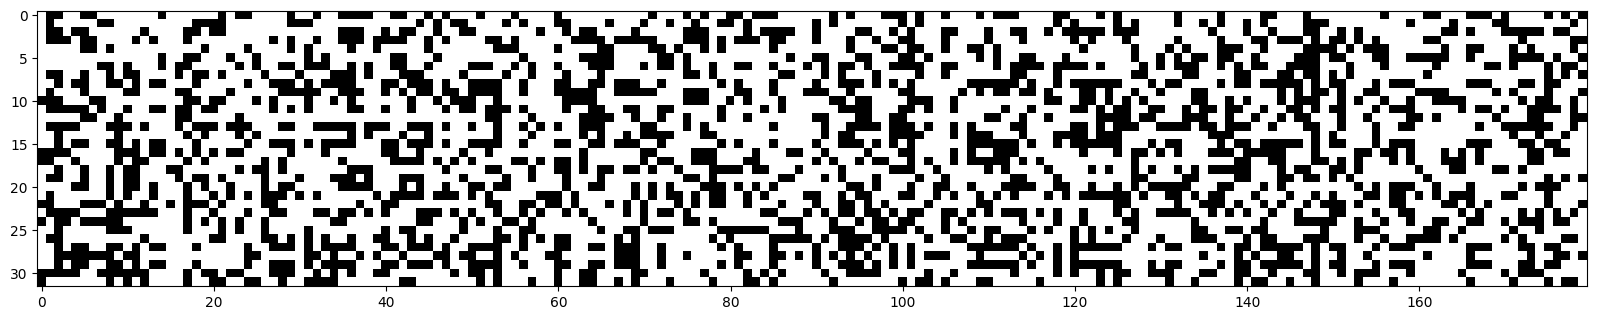

In [141]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

(array([  2.,   2.,   2.,   4.,   2.,   1.,   5.,  10.,  16.,  15.,  15.,
         32.,  40.,  48.,  79.,  90., 142., 121., 163., 209., 224., 259.,
        292., 286., 336., 390., 350., 352., 311., 288., 277., 235., 218.,
        198., 156., 123., 113., 109.,  66.,  45.,  42.,  22.,  25.,  18.,
          9.,   5.,   6.,   3.,   3.,   1.]),
 array([-21.73981667, -20.91756721, -20.09531776, -19.27306831,
        -18.45081886, -17.62856941, -16.80631996, -15.98407051,
        -15.16182106, -14.33957161, -13.51732216, -12.69507271,
        -11.87282326, -11.05057381, -10.22832436,  -9.40607491,
         -8.58382545,  -7.761576  ,  -6.93932655,  -6.1170771 ,
         -5.29482765,  -4.4725782 ,  -3.65032875,  -2.8280793 ,
         -2.00582985,  -1.1835804 ,  -0.36133095,   0.4609185 ,
          1.28316795,   2.1054174 ,   2.92766685,   3.74991631,
          4.57216576,   5.39441521,   6.21666466,   7.03891411,
          7.86116356,   8.68341301,   9.50566246,  10.32791191,
         11.150161

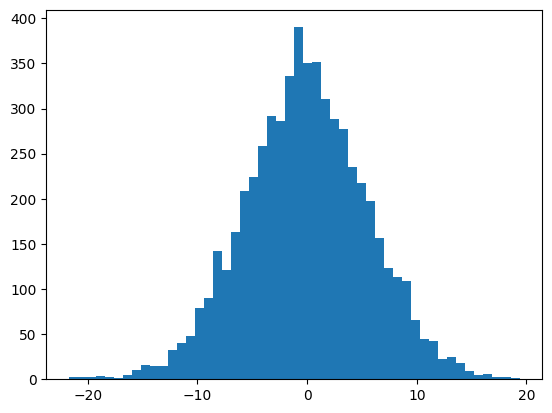

In [142]:
plt.hist(hpreact.view(-1).tolist(), 50)

into the tanh function flows `hpreact` which is `embcat @ W1 + b1`

`hpreact` is too far away from 0, this causes the problem.

In [143]:
# MLP revisited
n_embd = 10
n_hidden = 180

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden))   * 0.2
b1 = torch.randn(n_hidden)                               * 0.01
W2 = torch.randn((n_hidden, vocab_size))            * 0.01
b2 = torch.randn(vocab_size)                             * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

(array([2079.,  145.,   86.,   69.,   52.,   51.,   30.,   30.,   35.,
          29.,   23.,   36.,   37.,   27.,   18.,   28.,   25.,   20.,
          10.,   17.,   21.,   20.,   15.,   18.,   14.,   13.,   29.,
          23.,   11.,   18.,   22.,   29.,   16.,   12.,   14.,   17.,
          15.,   32.,   17.,   26.,   33.,   37.,   39.,   45.,   47.,
          41.,   42.,   80.,  137., 2030.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

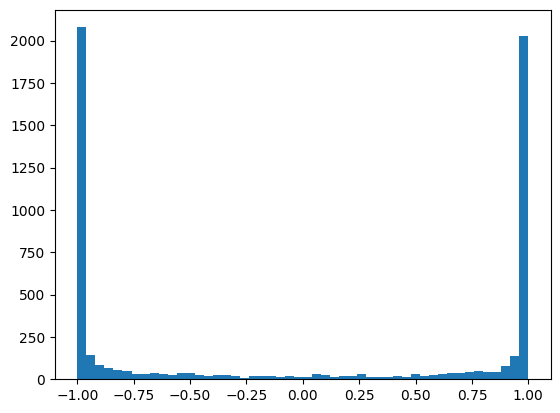

In [144]:
plt.hist(h.view(-1).tolist(), 50)

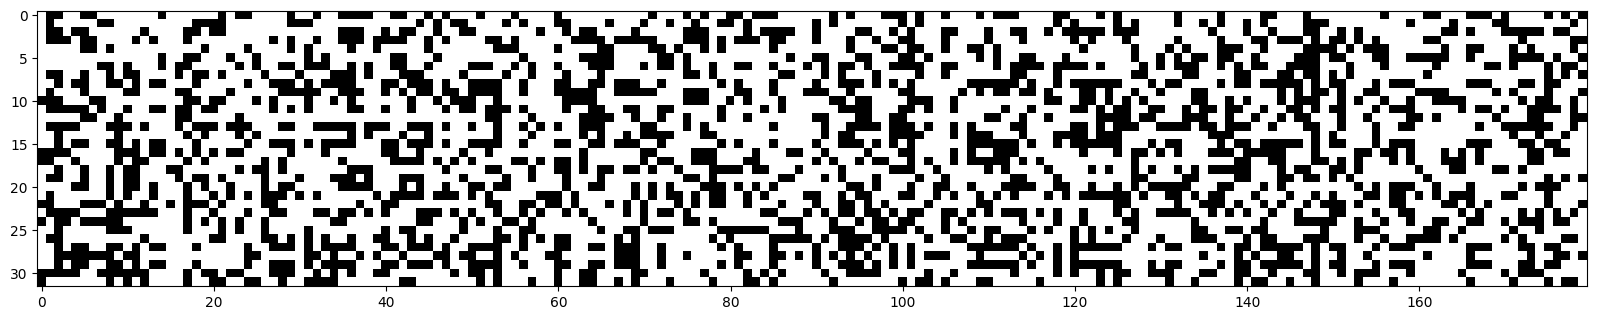

In [145]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

Now much better, no white here and histogram is also improved.

## 2.3 Formalizing intuitions

Because of some, nowadays not so relevant maths, we want the $std$ to be $gain / \sqrt{(fan in)}$.

In our case that will be $(5/3) / (30^{0.5})$

In [146]:
# MLP revisited
n_embd = 10
n_hidden = 180

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden))   * 0.2
b1 = torch.randn(n_hidden)                                  * (5 / 3) / ( (n_embd * block_size)**0.5 )
W2 = torch.randn((n_hidden, vocab_size))            * 0.01
b2 = torch.randn(vocab_size)                             * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [147]:
train_model()

      0/  10000: 3.3143
   1250/  10000: 2.0190
   2500/  10000: 2.1967
   3750/  10000: 2.3836
   5000/  10000: 2.2242
   6250/  10000: 2.4383
   7500/  10000: 2.0160
   8750/  10000: 2.3261
train 2.245147466659546
val 2.266249418258667


it basically gets the same result as before but now we are not using magic numbers which is nice.

## 2.4 Batchnorm

So we want our pre activation function numbers to be roughtly 0 mean standard gaussian. That is `hpreact`.

So, we should just normalize them to be unit gaussian.

In [148]:
hpreact.shape

torch.Size([32, 180])

In [149]:
hpreact.mean(0,keepdim= True).shape

torch.Size([1, 180])

In [150]:
# MLP revisited
n_embd = 10
n_hidden = 180

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * 0.2
b1 = torch.randn(n_hidden) * (5 / 3) / ((n_embd * block_size) ** 0.5)
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [151]:
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch
    xi = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[xi], Ytr[xi]

    # forward pass
    emb = C[Xb]  # embedding the charachters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[xi])

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 12000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:
        print(f"{i:7d}/{max_steps:7}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  10000: 3.3097
   1250/  10000: 2.5342
   2500/  10000: 2.2440
   3750/  10000: 2.4844
   5000/  10000: 2.6363
   6250/  10000: 2.1394
   7500/  10000: 2.0062
   8750/  10000: 2.0049


In [152]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    } [split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2368195056915283
val 2.262078046798706


We can basically take every linear layer and everywhere in the neural net we can add a batchnorm layer.

This will be learned and it will be good.

this has the result that now all the examples in the batch effect each other before the batch was used together but all the examples were independent. Now the aren't. But this is acctually good because it helps against overfitting and acts as a regularizer.

In [153]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [154]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    } [split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd+ bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.295088052749634
val 2.321303129196167


Now we can also evaluete on a single example at the end once we are done.

Because the batchnorm is removing the mean the bias is now not needed anymore. and we can remove it.

In [155]:
# MLP revisited
n_embd = 10
n_hidden = 180

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * 0.2

W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0


# BatchNorm parameters

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [156]:
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch
    xi = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[xi], Ytr[xi]

    # forward pass
    emb = C[Xb]  # embedding the charachters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)  # (32, 200)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[xi])

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 12000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:
        print(f"{i:7d}/{max_steps:7}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  10000: 3.3029
   1250/  10000: 2.4905
   2500/  10000: 2.6247
   3750/  10000: 2.1326
   5000/  10000: 2.0999
   6250/  10000: 2.4403
   7500/  10000: 1.8569
   8750/  10000: 2.1436


## 2.5 Performance Takeaways


- Understanding activation functions and thair statistics etc is important
- Don't want overconfident initialization
- Don't want to be in the tails of the activation function
- Always want to be standard gaussian
- We can use some numbers that make sense and divide by the etc.
- but batchnorm is better especially for deep networks

# 3. Further improvments and understanding

## 3.1 Torchifying code

In [9]:
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) /fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP


C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), #Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [11]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps*0.8 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:
        print(f"{i:7d}/{max_steps:7}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


    break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/  10000: 3.2696


## 3.2 Visualizing problems

layer 1 (      Tanh): mean +0.01, std 0.76, saturated: 20.59%
layer 3 (      Tanh): mean -0.02, std 0.70, saturated: 9.62%
layer 6 (      Tanh): mean +0.03, std 0.79, saturated: 27.28%
layer 8 (      Tanh): mean -0.02, std 0.69, saturated: 11.34%


Text(0.5, 1.0, 'activation distribution')

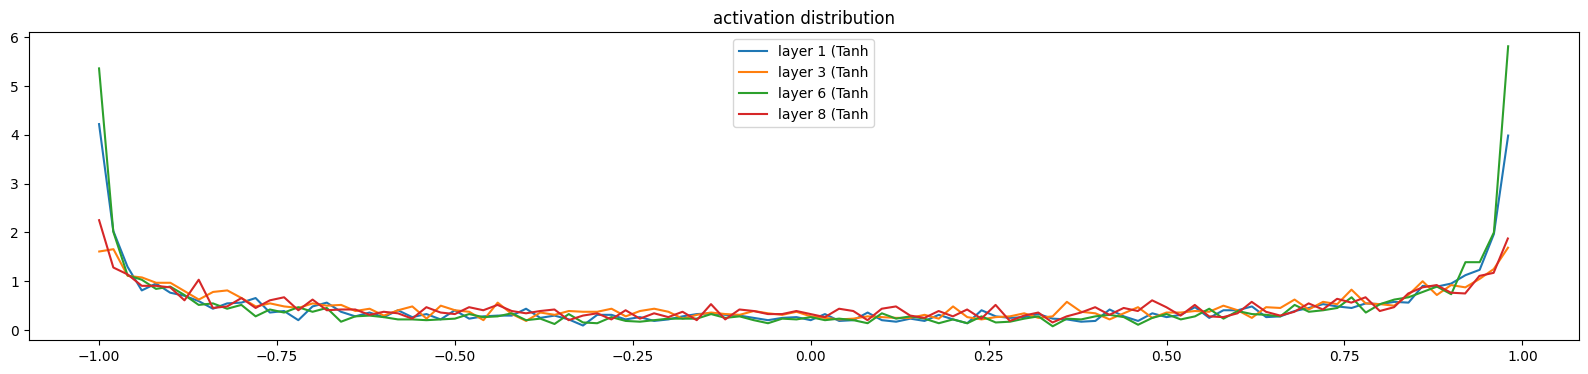

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 1 (      Tanh): mean +0.000019, std 4.919980e-04
layer 3 (      Tanh): mean +0.000010, std 4.959064e-04
layer 6 (      Tanh): mean +0.000010, std 3.268884e-04
layer 8 (      Tanh): mean +0.000002, std 3.242655e-04


Text(0.5, 1.0, 'gradient distribution')

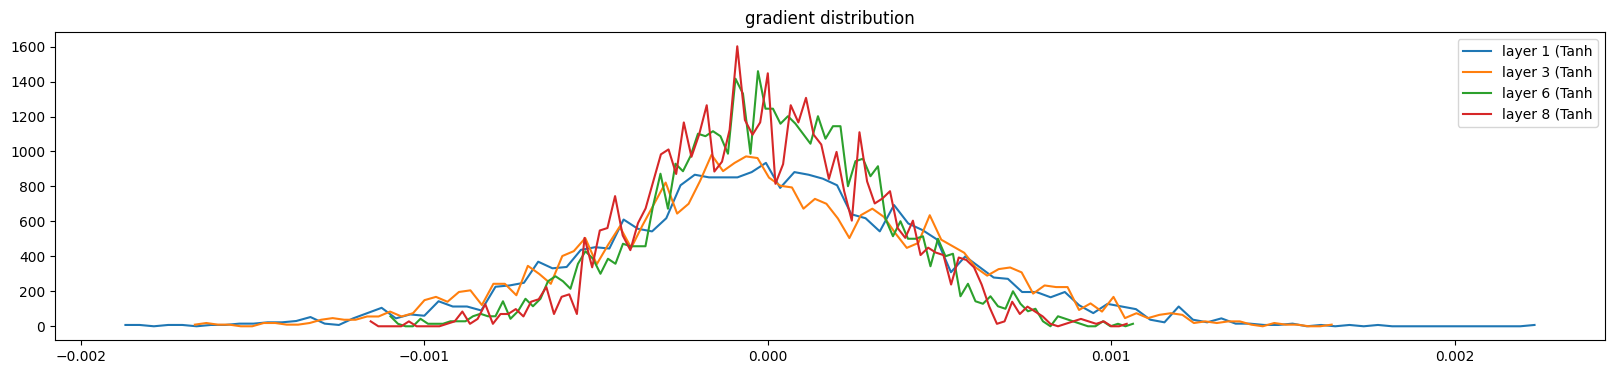

In [13]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight   (27, 10) | mean -0.000177 | std 1.728979e-03 | grad:data ratio 1.719904e-03
weight  (30, 100) | mean +0.000023 | std 1.760249e-03 | grad:data ratio 6.053284e-03
weight (100, 100) | mean +0.000018 | std 1.440117e-03 | grad:data ratio 8.749137e-03
weight (100, 100) | mean +0.000008 | std 1.240523e-03 | grad:data ratio 7.414586e-03
weight (100, 100) | mean -0.000007 | std 1.236462e-03 | grad:data ratio 7.419444e-03
weight (100, 100) | mean -0.000004 | std 1.010517e-03 | grad:data ratio 6.102393e-03
weight  (100, 27) | mean +0.000000 | std 2.455310e-02 | grad:data ratio 2.288172e+00


Text(0.5, 1.0, 'weights gradient distribution')

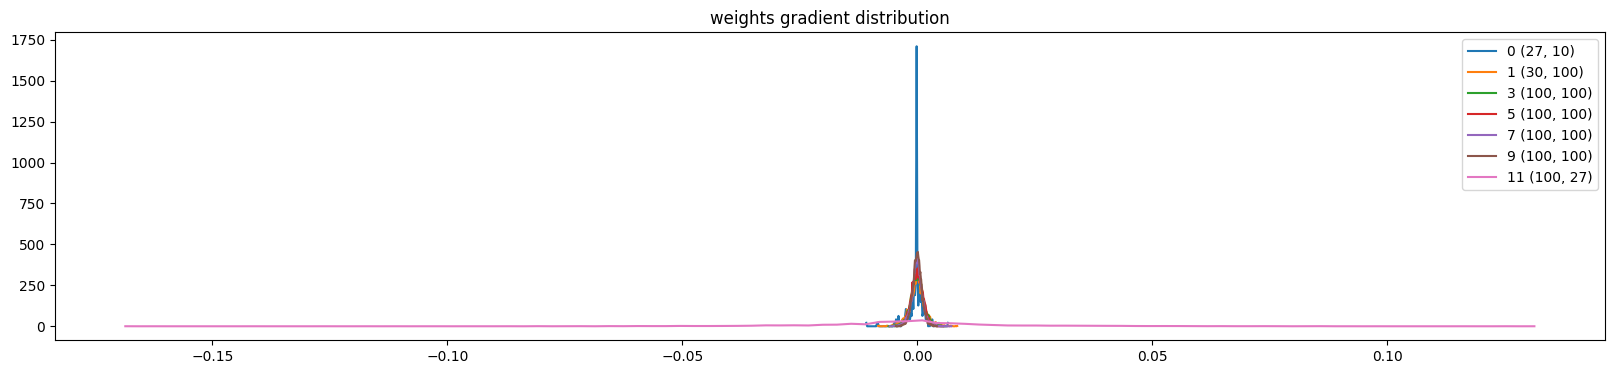

In [14]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(
            "weight %10s | mean %+f | std %e | grad:data ratio %e"
            % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

## 3.3 Fixing the update to data ratio

In [15]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps * 0.8 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:
        print(f"{i:7d}/{max_steps:7}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i == 1000:

        break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/  10000: 3.2607


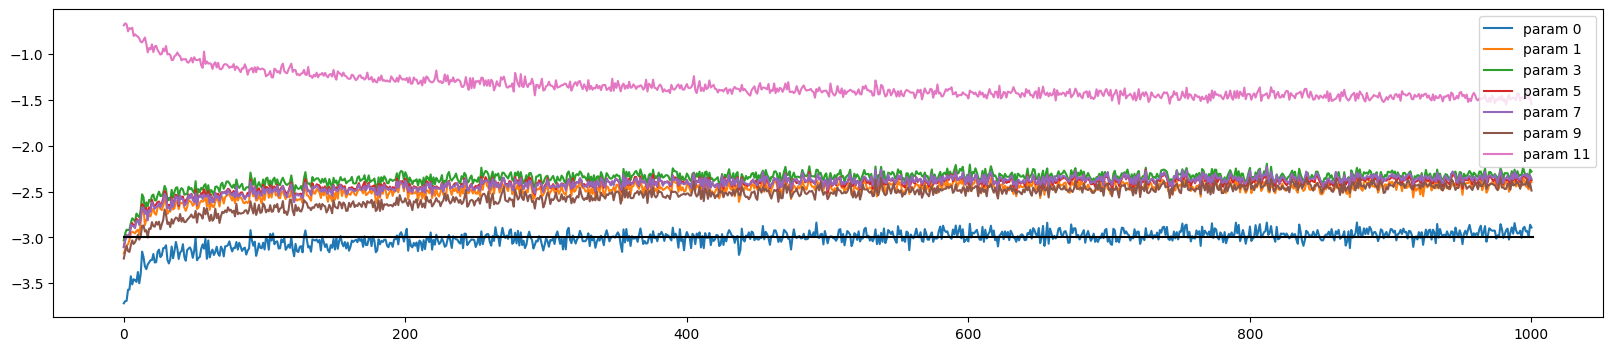

In [16]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

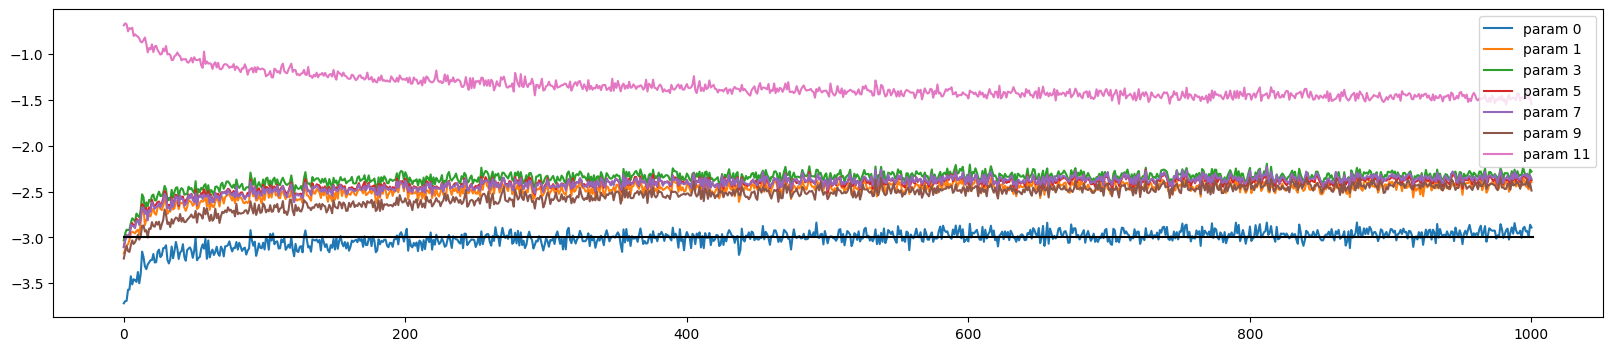

In [17]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

## 3.4 Adding the batchnorm back in


In [18]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP


C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd * block_size, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47497


In [19]:
# same optimization as last time
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < max_steps * 0.8 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % (max_steps / 8) == 0:
        print(f"{i:7d}/{max_steps:7}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]
        )

    if i == 1000:

        break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/  10000: 3.3138


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.84%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.50%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 14 (      Tanh): mean -0.02, std 0.64, saturated: 2.38%


Text(0.5, 1.0, 'activation distribution')

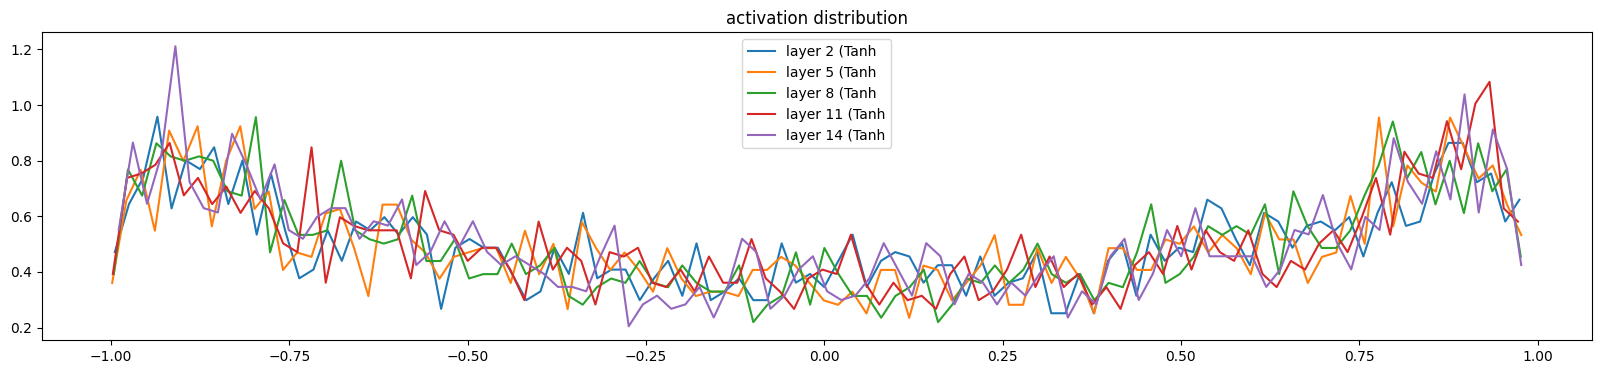

In [20]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean +0.000000, std 4.130030e-03
layer 5 (      Tanh): mean +0.000000, std 3.390656e-03
layer 8 (      Tanh): mean +0.000000, std 3.038690e-03
layer 11 (      Tanh): mean +0.000000, std 2.627232e-03
layer 14 (      Tanh): mean -0.000082, std 2.069649e-03


Text(0.5, 1.0, 'gradient distribution')

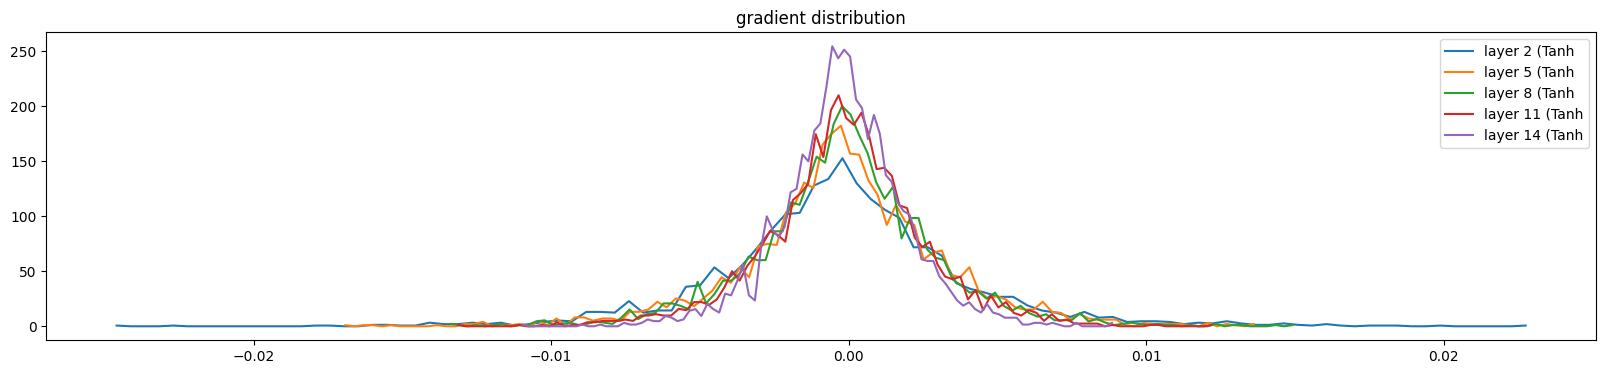

In [21]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

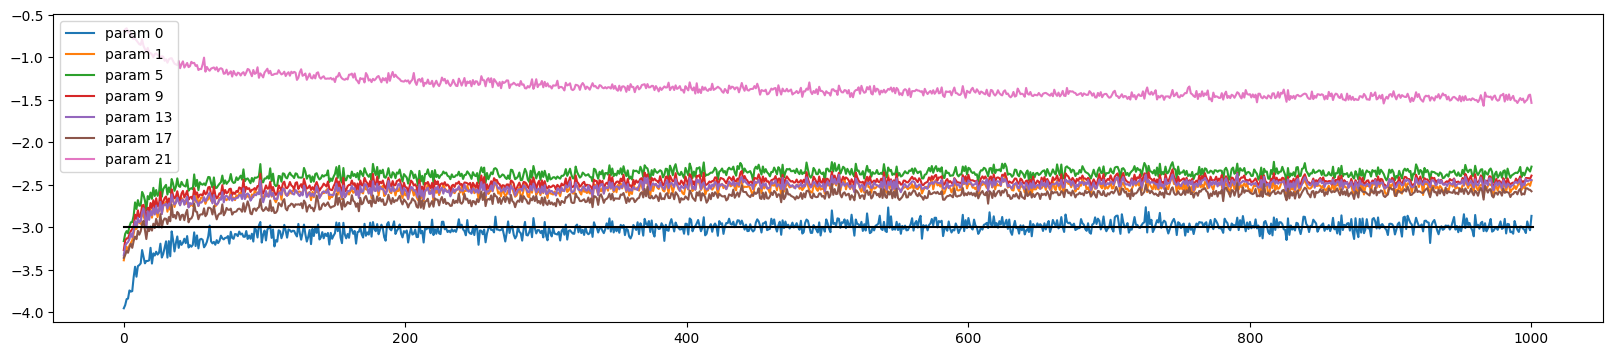

In [22]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

# 4. Errors for different models

Original model:
- train 2.634
- val 2.645


Fixing initialization (softmax being overconfident):
- train 2.306
- val 2.329

Shrinking bias to fix being in tail of tanh
- train 2.245
- val 2.262

Formalizing intuitions
- train 2.187
- val 2.214

Using batchnorm
- train 2.238553047180176
- val 2.2520413398742676

# 5. Sampling from the model

In [75]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

katab.
daraberley.
jera.
vabne.
ama.
ely.
dezeana.
larosleyly.
janee.
amee.
macleonne.
amaiz.
ayvon.
kasley.
nuton.
shely.
ley.
eylen.
alennalailkeolexkseeana.
ne.
